In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Business Case

A crypto stock buyer is a beginner in cryptocurrency. He has the understanding how cryptocurrency works, however since there are cryptocurrency variations available, he does not know which cryptocurrency to buy. Since he wanted to be on trend, he picked Bitcoin and Ethereum as his two of his best choices and also two of the popular cryptocurrency available out there.

As data scientists, it is our duty to help him guide with his current issue: which cryptocurrency to buy that is optimal for him as a beginner. We will create a model that determines whether Bitcoin or Ethereum is the best for his situation in the long run to help him get started with his cryptocurrency journey.

## Dataset
We got our data from an API called Cryptocompare API: https://min-api.cryptocompare.com. through this API and Web Scraping we can access the Bitcoin and Ethereum data needed for the model. 

## Machine learning model process

* Install libraries
* Import libraries
* Getting data through webscraping
* Split the Dataset into train and test
* Create the LSTM (Long Short Term Memory) Neural Network
* Make an LSTM Model using the Split Database
* Plot the predicted and actual data 

## Install Libraries

In [1]:
#import sys
!{sys.executable} -m pip install keras

In [2]:
#!{sys.executable} -m pip install seaborn

## Import Libraries

In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

## Getting Data through Webscraping

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'

res_eth = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
hist_eth = pd.DataFrame(json.loads(res_eth.content)['Data'])
hist_eth = hist_eth.set_index('time')
hist_eth.index = pd.to_datetime(hist_eth.index, unit='s')

res_btc = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist_btc = pd.DataFrame(json.loads(res_btc.content)['Data'])
hist_btc = hist_btc.set_index('time')
hist_btc.index = pd.to_datetime(hist_btc.index, unit='s')

target_col = 'close'

## Display the Head of the DataFrame 

In [ ]:
# ETH History
hist_eth.pop('conversionType')
hist_eth.pop('conversionSymbol')
hist_eth.head(5)

In [33]:
# BTC History
hist_btc.pop('conversionType')
hist_btc.pop('conversionSymbol')
hist_btc.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-07,19411.51,18909.97,19378.94,24908.46,4.773346e+08,19181.41
2020-12-08,19295.38,18227.31,19181.41,46151.65,8.665434e+08,18323.52
2020-12-09,18639.24,17669.15,18323.52,57997.45,1.057335e+09,18549.92
2020-12-10,18554.32,17920.56,18549.92,37500.96,6.848028e+08,18250.47
2020-12-11,18295.10,17598.13,18250.47,45166.17,8.093189e+08,18034.86


## Split the Dataset

In [34]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train_eth, test_eth = train_test_split(hist_eth, test_size=0.2)
train_btc, test_btc = train_test_split(hist_btc, test_size=0.2)

## Plot the Train and Test Dataset after Training

In [35]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

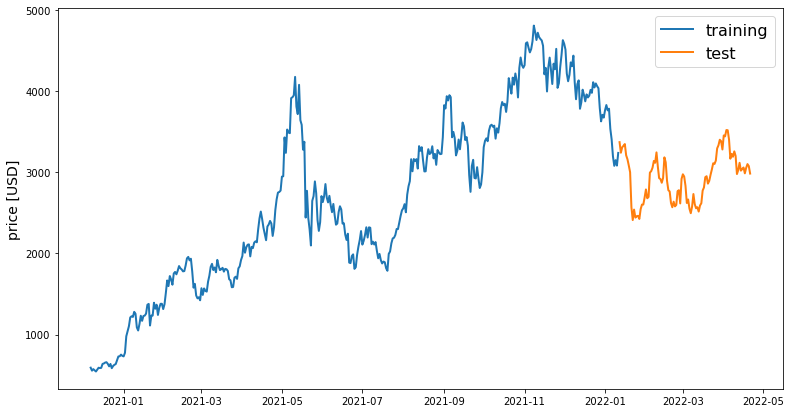

In [36]:
# ETH Plot
line_plot(train_eth[target_col], test_eth[target_col], 'training', 'test', title='')

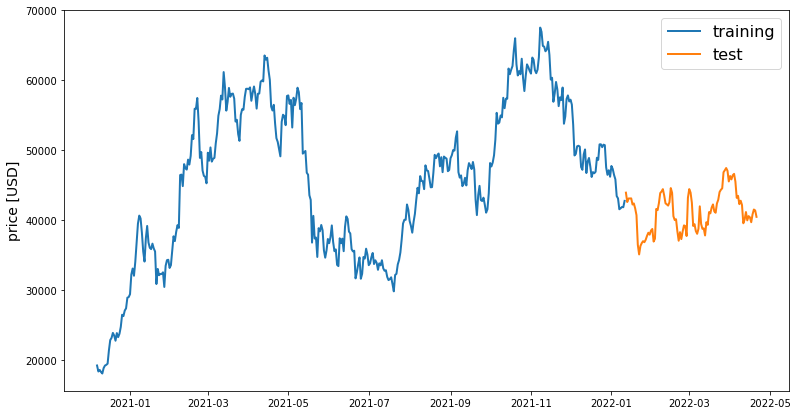

In [37]:
# BTC Plot
line_plot(train_btc[target_col], test_btc[target_col], 'training', 'test', title='')

## Create a Normalization Function

In [38]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

## Create a Data Extraction of Windows Function for Neural Network

In [39]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

## Create a Data Preparation for Neural Network Input

In [40]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

## Create the LTSM (Long Short Term Memory) Neural Network

In [42]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

## Set up Parameters

In [43]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

## Make a LSTM Model using the Split Dataset

In [44]:
# ETH LSTM Model 
train_eth, test_eth, X_train_eth, X_test_eth, y_train_eth, y_test_eth = prepare_data(
    hist_eth, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model_eth = build_lstm_model(
    X_train_eth, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

history_eth = model_eth.fit(
    X_train_eth, y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0113
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 3/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 13/20
13/13 [==============================

In [45]:
# BTC LSTM Model 
train_btc, test_btc, X_train_btc, X_test_btc, y_train_btc, y_test_btc = prepare_data(
    hist_btc, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model_btc = build_lstm_model(
    X_train_btc, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

history_btc = model_btc.fit(
    X_train_btc, y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0070
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 13/20
13/13 [==============================

## Predict the Dataset through the LSTM Model and Calculate the Mean Absolute Error

In [46]:
# ETH Predicted Model
targets_eth = test_eth[target_col][window_len:]
preds_eth = model_eth.predict(X_test_eth).squeeze()
mean_absolute_error(preds_eth, y_test_eth)

0.03741725892735945

In [47]:
# BTC Predicted Model
targets_btc = test_btc[target_col][window_len:]
preds_btc = model_btc.predict(X_test_btc).squeeze()
mean_absolute_error(preds_btc, y_test_btc)

0.03417087200996905

## Plot the Predicted vs Actual Plot

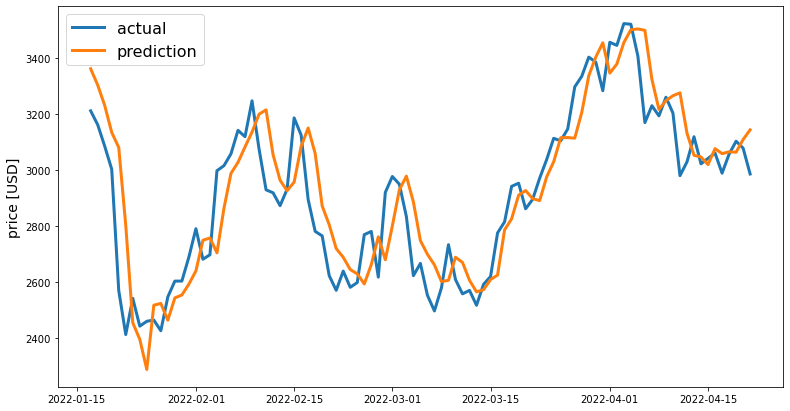

In [48]:
# ETH Predict vs Actual Plot
preds_eth = test_eth[target_col].values[:-window_len] * (preds_eth + 1)
preds_eth = pd.Series(index=targets_eth.index, data=preds_eth)
line_plot(targets_eth, preds_eth, 'actual', 'prediction', lw=3)

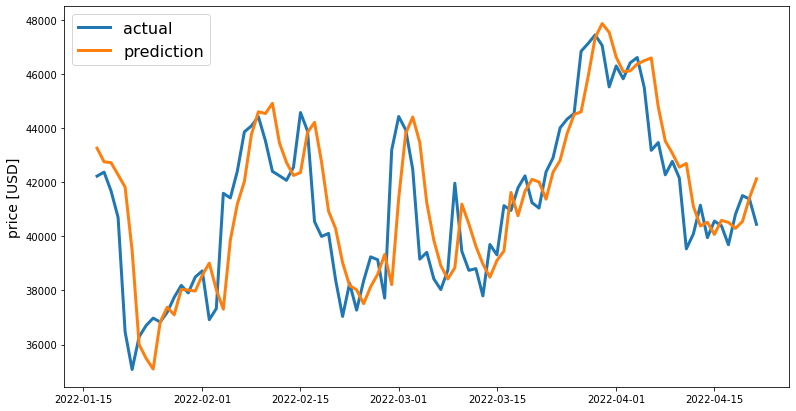

In [219]:
# BTC Predict vs Actual Plot
preds_btc = test_btc[target_col].values[:-window_len] * (preds_btc + 1)
preds_btc = pd.Series(index=targets_btc.index, data=preds_btc)
line_plot(targets_btc, preds_btc, 'actual', 'prediction', lw=3)

In [200]:
#line_plot(preds_eth, preds_btc, 'ETH Prediction', 'BTC Prediction', lw=3)

## Findings
We found that the model that we've created was accurate, at least to say that the prediction of the model is close enough to the actual data. Bitcoin's price has its highest peak on the first week of April 2022 while Ethereum's price has its highest peak on the last week of March 2022. Since the model is close enough to the actual data, we can reuse this model to determine what the future of cryptocurrency would look like to determine whether it is good to buy stock at that given timeframe.

## Conclusion
Based on the data plots above, we could assume that both Ethereum and Bitcoin could rise in future, at least for the next few months. According to the plots, we have concluded that the Bitcoin has more loss than Ethereum by price. As data scientists and based on the findings that we discovered, we would suggest that the stock buyer should spend on Ethereum rather than Bitcoin as a beginner.